# ACS2 in Maze Experiments
The following notebooks provides reproducible playground for experimenting how ACS2 agent behaves inside Maze environments.

## Imports and configuration
Load project files from upper directory (nasty solution).

In [1]:
import sys
sys.path.append('/home/norbert/Projects/pyalcs')

Import `pyalcs` module

In [2]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

from alcs.agent.acs2 import ACS2
from alcs.environment.maze import Maze

# Metrics
from alcs.helpers.metrics import \
    ClassifierPopulationSize,\
    ReliableClassifierPopulationSize,\
    AveragedFitnessScore,\
    StepsInTrial, \
    Experiment, \
    Trial, \
    AverageSpecificity,\
    AchievedKnowledge

# Helpers
from alcs.helpers.maze_utils import calculate_optimal_path_length

Other helpers

In [3]:
%matplotlib inline

from concurrent.futures import ProcessPoolExecutor, as_completed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Experiment
We are going to test ACS2 **agent** inside **maze** environment. The agent will have 2 tasks:
1. learn the shortest path to the goal state,
2. learn the internal model of the environment

### Maze
Currently there are 4 mazes implemented:
- `mazes/MazeF1.maze` (deterministic),
- `mazes/MazeF2.maze` (deterministic),
- `mazes/MazeF3.maze` (deterministic),
- `mazes/MazeF4.maze` (non-deterministic)
- `mazes/Maze5.maze` (deterministic)

Maze `MazeF4` introduces also the *aliasing* problem - the are two states that looks exactly the same for an agent.

In [6]:
# Location of the maze file
MAZE_LOCATION = 'mazes/BMaze5.maze'

And visualize it

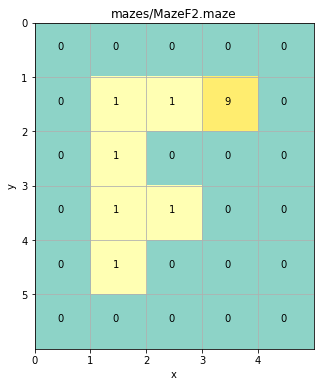

In [7]:
env = Maze(MAZE_LOCATION)

fig = plt.figure(figsize=(env.max_x, env.max_y))
ax = fig.add_subplot(111, aspect='equal')

# Cast matrix elements to int
imatrix = []
for row in env.matrix:
    imatrix.append([int(el) for el in row])

# Render maze as image
plt.imshow(imatrix, interpolation='none', cmap='Set3', aspect='auto',
           extent=[0, env.max_x, env.max_y, 0])

# Add labels to each cell
for x in range(0, env.max_x):
    for y in range(0, env.max_y):
        plt.text(x+0.4, y+0.5, env.matrix[y][x])

ax.set_title(MAZE_LOCATION)
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.xlim(0, env.max_x)
plt.ylim(env.max_y, 0)

plt.xticks(range(0, env.max_x))
plt.yticks(range(0, env.max_y))

plt.grid(True)
plt.show()

**Legend / reward map**:
- `0` is a $wall$ (cannot cross),
- `1` is a $path$ (reward $\rho = 0$),
- `9` is a $price$ (reward $\rho = 1000$)

### Optimal number of steps

In [8]:
optimal_numer_of_steps = calculate_optimal_path_length(env)
print("Optimal number of steps to reward: {:.2f}".format(optimal_numer_of_steps))

Optimal number of steps to reward: 2.50


### Agent
Agent interacts autonomously with the environment.

In this notebook it moves in maze for the certain number of steps.

> **Trial** is a successful run of agent when he manages to find the reward. After learning it should take him less and less steps to reach the goal.

At the beginning of each trial an agent is randomly placed inside the maze.
He can perceive 8 values (neighbourhood cells - N, NE, E, SE, S, SW, W, NW) and also move in 8 directions (N, NE, E, SE, S, SW, W, NW).

### Run the simulation
The whole simulation will run a certain number of times for certain number of steps.

In [9]:
# Number of experiments
EXPERIMENTS = 5

# Number of agent steps for each experiment
STEPS = 15000 # 10 000

Let's declare a function performing a single experiment.

We are:
1. initializing an agent,
2. instructing him to collect specified measurements,
3. initializing the environment,
4. running the simulation,
5. returning obtained classifiers and metrics


Then firing many jobs in parallel.

In [10]:
agent = ACS2()

# Specify which metrics will be collected
agent.add_metrics_handlers([
    StepsInTrial('steps'),
    Experiment('experiment_id'),
    Trial('trial'),
    ClassifierPopulationSize('total_classifiers'),
    ReliableClassifierPopulationSize('reliable_classifiers'),
    AchievedKnowledge('knowledge'),
    AverageSpecificity('specificity')
])

metrics = agent.evaluate(env, EXPERIMENTS, STEPS)

## Performance metrics
Let's have a look how the performance metrics look like by taking 5 random samples:

In [11]:
# Convert to Pandas data frame
all_metrics = pd.DataFrame(metrics)

all_metrics.sample(5)

,experiment_id,knowledge,reliable_classifiers,specificity,steps,total_classifiers,trial
923,2,64.705882,74,0.270833,16,84,115
1109,2,64.705882,81,0.273148,27,81,301
1236,3,47.058824,45,0.292808,50,146,28
206,0,64.705882,127,0.300551,50,136,207
1713,4,64.705882,104,0.296875,50,128,98


Let's define a helper function for measuring an average value across all experiments:

In [12]:
def get_avg_per_trial(performance, colname):
    avg_metric_per_trial = pd.DataFrame(performance.groupby('trial')[colname].mean())
    avg_metric_per_trial.reset_index(inplace=True)
    return avg_metric_per_trial

### Number of steps to food
Measures if the classifier actually *learns* something along the time.

> **Number of steps to food** - How many steps were needed in **each trial** to found the reward.

This plot is not representative since the algorithm is set for pure exploration.

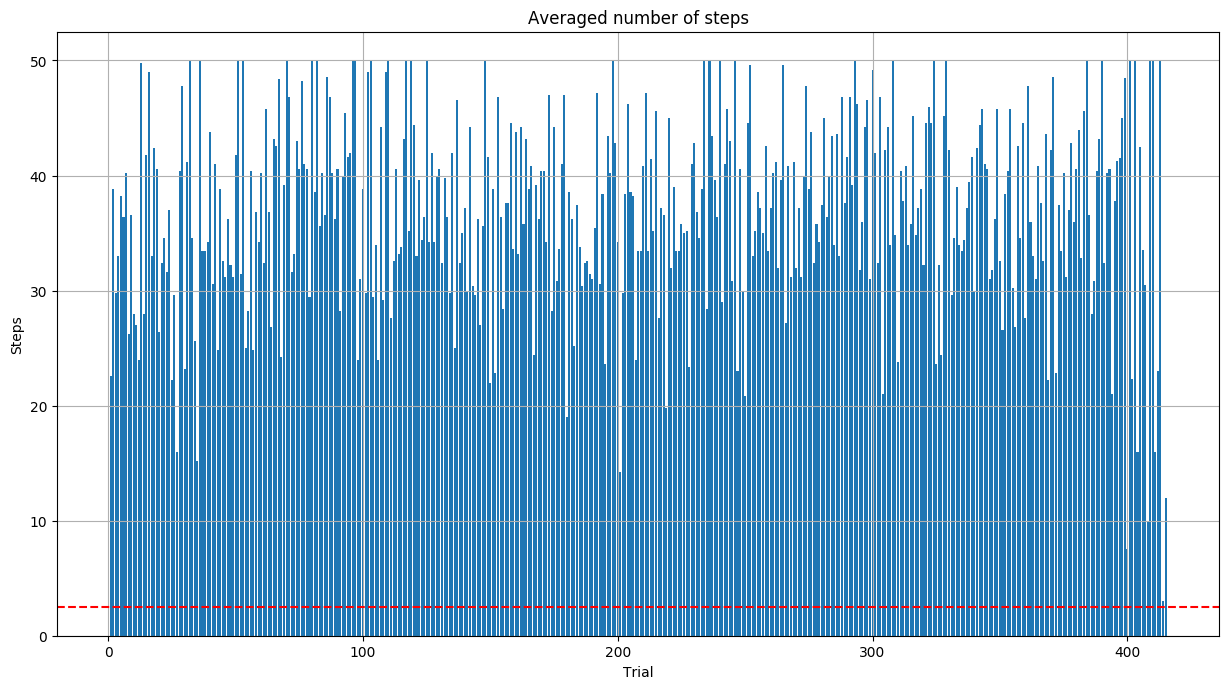

In [13]:
steps_per_trial = get_avg_per_trial(all_metrics, 'steps')

fig = plt.figure(figsize=(15, 8), dpi=100)

plt.bar(steps_per_trial['trial'], steps_per_trial['steps'])
plt.axhline(optimal_numer_of_steps, color='r', linestyle='dashed')

plt.title('Averaged number of steps')
plt.xlabel('Trial')
plt.ylabel('Steps')

plt.grid(True)

plt.show()

### Achieved knowledge
Measures if an agent is *learning* the environment.

> **Achieved knowledge** - test whether or not there is a **reliable classifier** for each transition $(\sigma_{1}, \alpha, \sigma_{2})$ with $\sigma_{1} \neq \sigma_{2}$ that can be applied in $\sigma_{1}$ and anticipates $\sigma_{2}$ correctly.

This metric is calculated after each trial done by the agent.

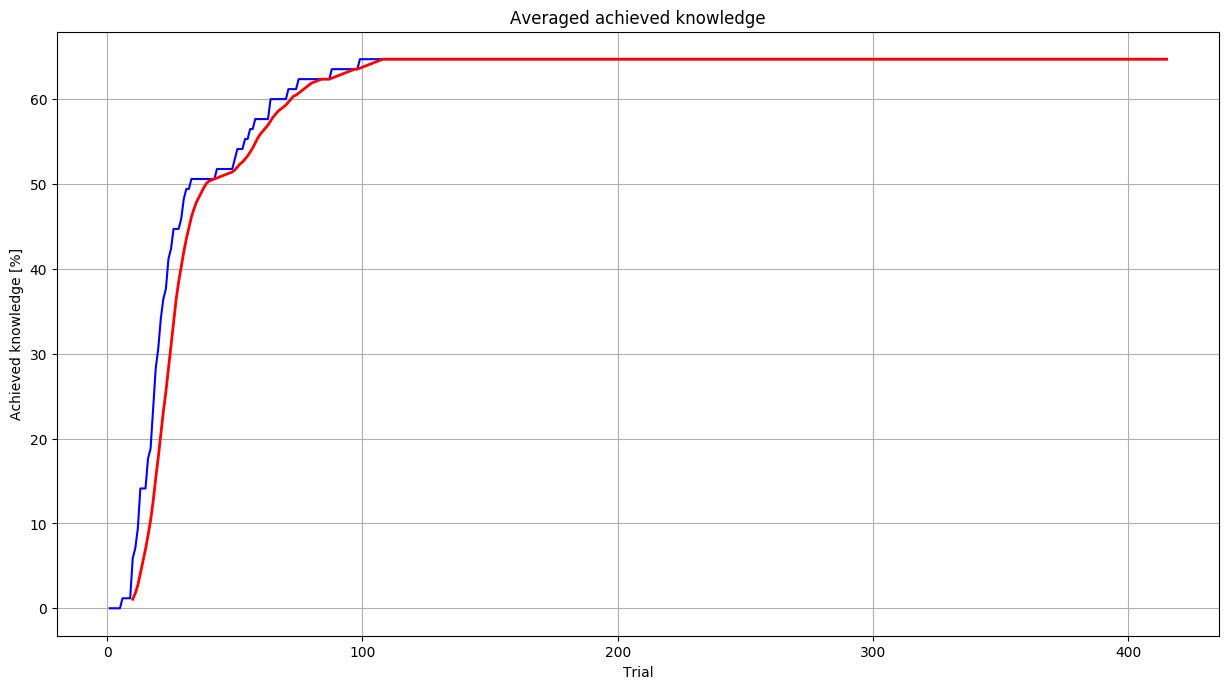

In [14]:
knowledge_per_trial = get_avg_per_trial(all_metrics, 'knowledge')
knowledge_per_trial['MA'] = knowledge_per_trial['knowledge'].rolling(window=10).mean()

fig = plt.figure(figsize=(15, 8), dpi=100)

plt.plot(knowledge_per_trial['trial'], knowledge_per_trial['knowledge'], 'b')
plt.plot(knowledge_per_trial['trial'], knowledge_per_trial['MA'], 'r', linewidth=2.0)

plt.title('Averaged achieved knowledge')
plt.xlabel('Trial')
plt.ylabel('Achieved knowledge [%]')

plt.grid(True)

plt.show()

### Classifiers
What is the number of classifiers across steps

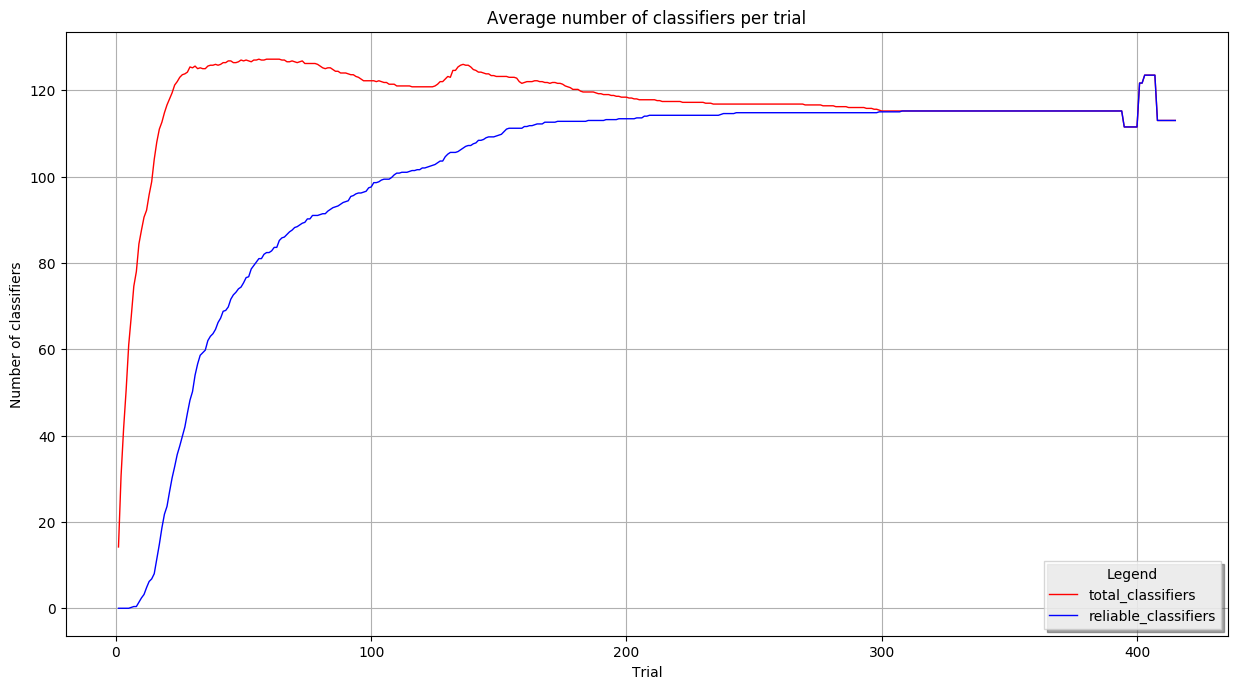

In [15]:
all_classifiers_per_trial = get_avg_per_trial(all_metrics, 'total_classifiers')
reliable_classifiers_per_trial = get_avg_per_trial(all_metrics, 'reliable_classifiers')

fig = plt.figure(figsize=(15, 8), dpi=100)

plt.plot(all_classifiers_per_trial['trial'], all_classifiers_per_trial['total_classifiers'], 'r', linewidth=1)
plt.plot(reliable_classifiers_per_trial['trial'], reliable_classifiers_per_trial['reliable_classifiers'], 'b', linewidth=1)
plt.title('Average number of classifiers per trial')
plt.xlabel('Trial')
plt.ylabel('Number of classifiers')

plt.grid(True)
plt.legend(loc="lower right", shadow=True, title="Legend", fancybox=False)

plt.show()

### Specificity measure
Measure the *generalization* in classifier population.

> **Specificity measure** - Equal to the **sum** of all specialized attributed in condition part of all classifiers in population **divided** by the number of classifiers **times** the length of  the perception $\sigma$.

You can read more about this metric in "*Introducing a Genetic Generalization Pressure to the
Anticipatory Classfierier System - Part2: Performance Analysis*" by Martin V. Butz.

Plot should change after modifing the agent's *mutation* and *cross over* values. The author claims that the best generalization was reached for mutation rate $\mu = 0.4$.

Plot the results

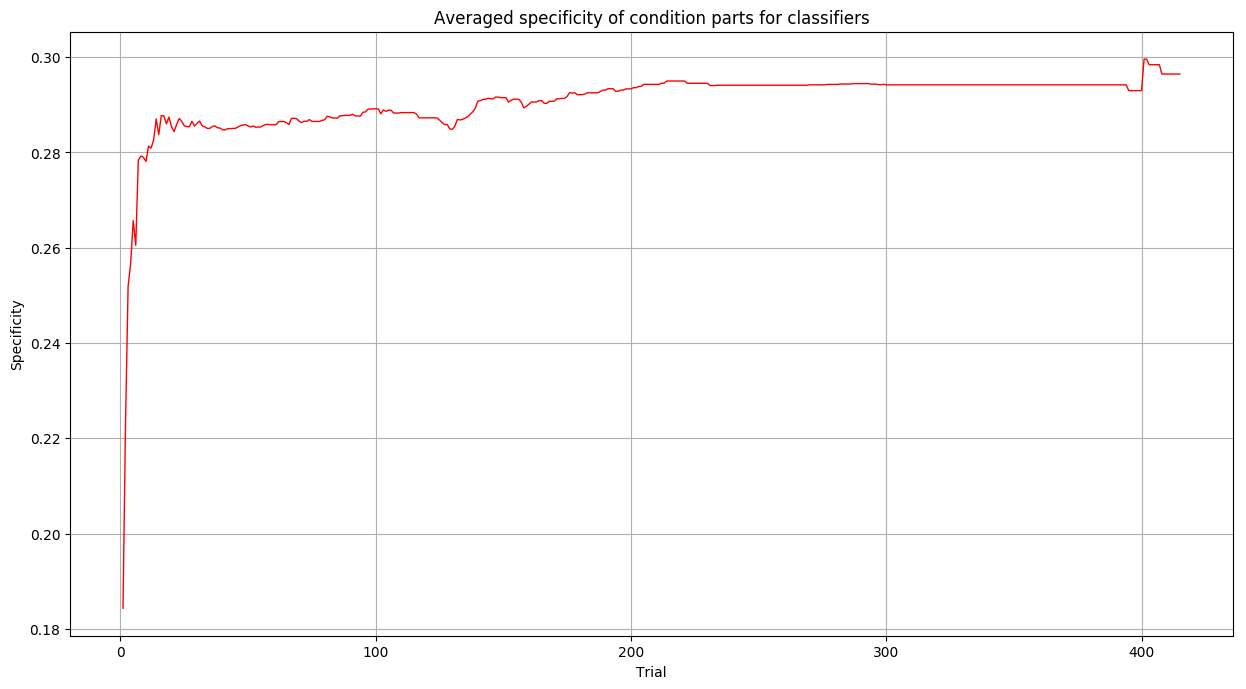

In [16]:
spec_per_trial = get_avg_per_trial(all_metrics, 'specificity')

fig = plt.figure(figsize=(15, 8), dpi=100)

plt.plot(spec_per_trial['trial'], spec_per_trial['specificity'], 'r', linewidth=1)
plt.title('Averaged specificity of condition parts for classifiers')
plt.xlabel('Trial')
plt.ylabel('Specificity')

plt.grid(True)

plt.show()

We can observe that the value stabilizes near 0.45 which means most elements of condition part is wildcards.

We can execute another experiment, but this time also the mutation ratio will change.

The following image presents how the alternative plot can look like:
![title](temp/generalization.png)

Prepare variables for the simulation

In [17]:
# Create an array containing possible values of mutation rate
mutation_rates = np.linspace(0, 1, 9)

# Number of experiments
EXPERIMENTS = 10

# Number of steps in each experiment
STEPS = 10000

Run the simulation

In [18]:
performance = pd.DataFrame()

for experiment in range(EXPERIMENTS):
    print("Experiment: [{}]".format(experiment))
    
    for mutation_rate in mutation_rates:
        print("\tMutation rate: {}".format(mutation_rate))
        
        # Re-initialize the environment
        env = Maze(MAZE_LOCATION)

        # Initialize the agent with metric handler
        agent = ACS2(mu=mutation_rate)
        agent.add_metrics_handlers([
            ActualStep('time'),
            AveragedConditionSpecificity('average_specificity'),
        ])
        
        # Evaluate algorithm
        #classifiers, metrics = agent.evaluate(env, STEPS)

        # Add information about the experiment into metrics
        metrics['experiment_id'] = [experiment] * len(metrics['time'])
        metrics['mutation_rate'] = [mutation_rate] * len(metrics['time'])

        # Append performance metrics
        performance = performance.append(pd.DataFrame(metrics))

Experiment: [0]
	Mutation rate: 0.0


TypeError: __init__() got an unexpected keyword argument 'mu'

To calculate the condition specificity we will take it's value obtained after last step in each experiment and average it.

In [ ]:
def get_avg_specificity_by_mutation_rate(performance):
    last_as_by_experiment = pd.DataFrame(performance
                                         .groupby(['experiment_id','mutation_rate'])['average_specificity']
                                         .last())
    last_as_by_experiment.reset_index(inplace=True)
    
    avg_as_by_mutation_rate = pd.DataFrame(last_as_by_experiment
                                           .groupby(['mutation_rate'])['average_specificity']
                                           .mean())
    avg_as_by_mutation_rate.reset_index(inplace=True)
    
    return avg_as_by_mutation_rate

See how the results look like

In [ ]:
avg_as_by_mutation_rate = get_avg_specificity_by_mutation_rate(performance)
avg_as_by_mutation_rate

In [ ]:
fig = plt.figure(figsize=(15, 8), dpi=100)

plt.plot(avg_as_by_mutation_rate['mutation_rate'],
         avg_as_by_mutation_rate['average_specificity'], 'r', linewidth=2)
plt.title('Averaged specificity ratio')
plt.xlabel('Mutation rate')
plt.ylabel('Specificity')

plt.grid(True)
plt.show()